# Predict Credit Card Consumption

### Importing Packages

In [52]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from scipy.stats import norm,skew
import seaborn as sns
%matplotlib inline

In [53]:
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [54]:
# Create Data audit Report for continuous variables
def continues_variable_summ(x):
    return pd.Series([x.count(),x.isnull().sum(),x.sum(),x.mean(),x.median(),x.std(),x.var(),x.min(),x.max(),x.quantile(0.01),
                     x.quantile(0.05),x.quantile(0.10),x.quantile(0.25),x.quantile(0.50),x.quantile(0.75),
                     x.quantile(0.90),x.quantile(0.99)],
                    index=['N','NMISS','SUM','MEAN','MEDIAN','STD','VAR','MIN','MAX','P1','P5','P10','P25','P50','P75','P90','P99'])

In [55]:
# Create Data audit Report for categorical variables
def categorical_variable_summ(x):
    Mode=x.value_counts().sort_values(ascending=False)[0:1].reset_index()
    return pd.Series([x.count(),x.isnull().sum(),Mode.iloc[0,0],Mode.iloc[0,1],round(Mode.iloc[0,1]*100/x.count(),2)],
                    index=['N','NMISS','MODE','FREQ','PERCENT'])

In [56]:
#Missing Value imputation for continuous and categorical variables
def missing_imputation(x,stats='mean'):
    if (x.dtypes == 'float64') | (x.dtypes == 'int64'):
        x=x.fillna(x.mean()) if stats=='mean' else x.fillna(x.median())
    else:
        x=x.fillna(x.mode().iloc[0])
    return x


In [57]:
#An utility function of creating dummy variales
def create_dummies(df,colname):
    col_dummies=pd.get_dummies(df[colname],prefix=colname,drop_first=True)
    df=pd.concat([df,colname],axis=1)
    df.drop(colname,axis=1,inplace=True)
    return df

## Importing Data 

###### (a) Customer Demographics


In [58]:
CustomerDemographics=pd.read_excel(r"C:\Users\Sushant\Desktop\Machine Learning\11. Capstone Case Study - Predict Cred Card Consumption\CustomerDemographics.xlsx")

###### (b) Customer Behaviorial data (information on liabilities, assets and history of transactions with bank of each customer)Data has been provided for a particular set of customer's credit card spend in the previous 3 months (Apr, May & June) and their expected average spend in the coming 3 Months (Jul, Aug, Sep)

In [59]:
CustomerBehaviorData=pd.read_excel(r"C:\Users\Sushant\Desktop\Machine Learning\11. Capstone Case Study - Predict Cred Card Consumption\CustomerBehaviorData.xlsx")

###### (c) Credit Consumption

In [60]:
CreditConsumptionData=pd.read_excel(r"C:\Users\Sushant\Desktop\Machine Learning\11. Capstone Case Study - Predict Cred Card Consumption\CreditConsumptionData.xlsx")

In [61]:
CustomerDemographics

,ID,account_type,gender,age,Income,Emp_Tenure_Years,Tenure_with_Bank,region_code,NetBanking_Flag,Avg_days_between_transaction
0,19427,current,M,63,MEDIUM,30.1,10,628.0,1,5.0
1,16150,current,M,36,MEDIUM,14.4,10,656.0,0,12.0
2,11749,current,F,28,MEDIUM,4.8,10,314.0,1,13.0
3,11635,current,M,32,MEDIUM,9.6,2,614.0,1,19.0
4,8908,current,M,32,HIGH,12.0,7,750.0,1,18.0
...,...,...,...,...,...,...,...,...,...,...
19995,1270,current,F,66,MEDIUM,32.2,6,354.0,1,7.0
19996,15992,current,M,53,MEDIUM,19.8,5,809.0,0,14.0
19997,7081,current,F,66,MEDIUM,18.4,1,466.0,0,10.0
19998,6821,current,M,32,LOW,6.0,8,619.0,0,17.0


## Data Inspecting

In [62]:
CustomerDemographics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 10 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   ID                            20000 non-null  int64  
 1   account_type                  19999 non-null  object 
 2   gender                        19999 non-null  object 
 3   age                           20000 non-null  int64  
 4   Income                        19999 non-null  object 
 5   Emp_Tenure_Years              20000 non-null  float64
 6   Tenure_with_Bank              20000 non-null  int64  
 7   region_code                   19999 non-null  float64
 8   NetBanking_Flag               20000 non-null  int64  
 9   Avg_days_between_transaction  19997 non-null  float64
dtypes: float64(3), int64(4), object(3)
memory usage: 1.5+ MB


In [63]:
CustomerDemographics.columns

Index(['ID', 'account_type', 'gender', 'age', 'Income', 'Emp_Tenure_Years',
       'Tenure_with_Bank', 'region_code', 'NetBanking_Flag',
       'Avg_days_between_transaction'],
      dtype='object')

In [64]:
CustomerBehaviorData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 39 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   ID                     20000 non-null  int64  
 1   cc_cons_apr            20000 non-null  float64
 2   dc_cons_apr            20000 non-null  float64
 3   cc_cons_may            19999 non-null  float64
 4   dc_cons_may            20000 non-null  float64
 5   cc_cons_jun            20000 non-null  float64
 6   dc_cons_jun            19999 non-null  float64
 7   cc_count_apr           19999 non-null  float64
 8   cc_count_may           20000 non-null  int64  
 9   cc_count_jun           20000 non-null  int64  
 10  dc_count_apr           20000 non-null  int64  
 11  dc_count_may           20000 non-null  int64  
 12  dc_count_jun           20000 non-null  int64  
 13  card_lim               20000 non-null  int64  
 14  personal_loan_active   20000 non-null  int64  
 15  ve

In [65]:
CustomerBehaviorData.columns

Index(['ID', 'cc_cons_apr', 'dc_cons_apr', 'cc_cons_may', 'dc_cons_may',
       'cc_cons_jun', 'dc_cons_jun', 'cc_count_apr', 'cc_count_may',
       'cc_count_jun', 'dc_count_apr', 'dc_count_may', 'dc_count_jun',
       'card_lim', 'personal_loan_active', 'vehicle_loan_active',
       'personal_loan_closed', 'vehicle_loan_closed', 'investment_1',
       'investment_2', 'investment_3', 'investment_4', 'debit_amount_apr',
       'credit_amount_apr', 'debit_count_apr', 'credit_count_apr',
       'max_credit_amount_apr', 'debit_amount_may', 'credit_amount_may',
       'credit_count_may', 'debit_count_may', 'max_credit_amount_may',
       'debit_amount_jun', 'credit_amount_jun', 'credit_count_jun',
       'debit_count_jun', 'max_credit_amount_jun', 'loan_enq', 'emi_active'],
      dtype='object')

In [66]:
CreditConsumptionData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   ID       20000 non-null  int64  
 1   cc_cons  15000 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 312.6 KB


In [67]:
CreditConsumptionData.columns

Index(['ID', 'cc_cons'], dtype='object')

#### Merging Files

In [68]:
fm=pd.merge(CreditConsumptionData,CustomerBehaviorData)

In [69]:
fm1=pd.merge(fm,CustomerDemographics)

In [70]:
fm1

,ID,cc_cons,cc_cons_apr,dc_cons_apr,cc_cons_may,dc_cons_may,cc_cons_jun,dc_cons_jun,cc_count_apr,cc_count_may,...,emi_active,account_type,gender,age,Income,Emp_Tenure_Years,Tenure_with_Bank,region_code,NetBanking_Flag,Avg_days_between_transaction
0,12554,20014.0,24893.000,378.00,10288.00,29664.00,16291.40,11432.00,2.0,26,...,1674.09,current,M,35,MEDIUM,15.0,1,708.0,0,17.0
1,17645,10173.0,18941.620,966.00,20672.00,287.00,4217.00,885.00,1.0,7,...,13043.34,current,M,35,HIGH,15.0,6,123.0,0,14.0
2,7604,16095.0,5678.870,2724.00,1964.50,3933.11,23956.25,5168.00,43.0,32,...,25375.27,current,M,55,MEDIUM,24.5,1,802.0,1,3.0
3,1590,7707.0,30489.500,1236.00,12609.88,9138.14,17521.00,13650.30,53.0,1,...,3544.33,current,F,29,MEDIUM,4.5,6,867.0,1,4.0
4,16556,96408.0,7441.400,6906.04,4364.00,1939.00,2121.00,6829.18,67.0,47,...,12780.44,current,M,34,MEDIUM,12.6,4,802.0,1,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,12512,NaN,4641.500,5979.58,6008.61,4410.00,41743.00,1884.00,26.0,1,...,7870.88,current,M,35,MEDIUM,13.5,1,523.0,0,7.0
19996,14224,NaN,4994.450,2805.37,23214.00,5870.00,1041.00,1008.73,37.0,56,...,3668.30,current,M,53,MEDIUM,9.9,7,723.0,1,2.0
19997,18740,NaN,3262.145,2871.00,7335.25,11774.04,4130.00,1413.00,12.0,77,...,5450.34,current,M,62,HIGH,37.8,8,863.0,1,16.0
19998,18134,NaN,12824.010,4866.00,12242.48,284.00,15132.77,37911.00,67.0,1,...,59.29,current,M,34,MEDIUM,12.6,4,882.0,0,13.0


In [71]:
fm1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20000 entries, 0 to 19999
Data columns (total 49 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   ID                            20000 non-null  int64  
 1   cc_cons                       15000 non-null  float64
 2   cc_cons_apr                   20000 non-null  float64
 3   dc_cons_apr                   20000 non-null  float64
 4   cc_cons_may                   19999 non-null  float64
 5   dc_cons_may                   20000 non-null  float64
 6   cc_cons_jun                   20000 non-null  float64
 7   dc_cons_jun                   19999 non-null  float64
 8   cc_count_apr                  19999 non-null  float64
 9   cc_count_may                  20000 non-null  int64  
 10  cc_count_jun                  20000 non-null  int64  
 11  dc_count_apr                  20000 non-null  int64  
 12  dc_count_may                  20000 non-null  int64  
 13  d

In [72]:
fm1.columns

Index(['ID', 'cc_cons', 'cc_cons_apr', 'dc_cons_apr', 'cc_cons_may',
       'dc_cons_may', 'cc_cons_jun', 'dc_cons_jun', 'cc_count_apr',
       'cc_count_may', 'cc_count_jun', 'dc_count_apr', 'dc_count_may',
       'dc_count_jun', 'card_lim', 'personal_loan_active',
       'vehicle_loan_active', 'personal_loan_closed', 'vehicle_loan_closed',
       'investment_1', 'investment_2', 'investment_3', 'investment_4',
       'debit_amount_apr', 'credit_amount_apr', 'debit_count_apr',
       'credit_count_apr', 'max_credit_amount_apr', 'debit_amount_may',
       'credit_amount_may', 'credit_count_may', 'debit_count_may',
       'max_credit_amount_may', 'debit_amount_jun', 'credit_amount_jun',
       'credit_count_jun', 'debit_count_jun', 'max_credit_amount_jun',
       'loan_enq', 'emi_active', 'account_type', 'gender', 'age', 'Income',
       'Emp_Tenure_Years', 'Tenure_with_Bank', 'region_code',
       'NetBanking_Flag', 'Avg_days_between_transaction'],
      dtype='object')

In [73]:
fm1.shape

(20000, 49)

In [74]:
#Cardianality
fm1.nunique()

ID                              20000
cc_cons                         12260
cc_cons_apr                      8459
dc_cons_apr                      3861
cc_cons_may                      8504
dc_cons_may                      4053
cc_cons_jun                      7347
dc_cons_jun                      3019
cc_count_apr                       50
cc_count_may                       58
cc_count_jun                       67
dc_count_apr                       41
dc_count_may                       39
dc_count_jun                       54
card_lim                          308
personal_loan_active                1
vehicle_loan_active                 1
personal_loan_closed                1
vehicle_loan_closed                 1
investment_1                      691
investment_2                      532
investment_3                      246
investment_4                      115
debit_amount_apr                 8724
credit_amount_apr                8153
debit_count_apr                    63
credit_count

In [75]:
# In case we have huge data and we don't want to make copy of the original data
# We generally go with the option of getting columns/variable names for object and numeric type
numeric_columns=fm1.select_dtypes(include=['float64','int64']).columns
object_columns=fm1.select_dtypes(include=['object']).columns

In [76]:
fm1[numeric_columns]

,ID,cc_cons,cc_cons_apr,dc_cons_apr,cc_cons_may,dc_cons_may,cc_cons_jun,dc_cons_jun,cc_count_apr,cc_count_may,...,credit_count_jun,debit_count_jun,max_credit_amount_jun,emi_active,age,Emp_Tenure_Years,Tenure_with_Bank,region_code,NetBanking_Flag,Avg_days_between_transaction
0,12554,20014.0,24893.000,378.00,10288.00,29664.00,16291.40,11432.00,2.0,26,...,2,65,50836.0,1674.09,35,15.0,1,708.0,0,17.0
1,17645,10173.0,18941.620,966.00,20672.00,287.00,4217.00,885.00,1.0,7,...,21,63,23226.0,13043.34,35,15.0,6,123.0,0,14.0
2,7604,16095.0,5678.870,2724.00,1964.50,3933.11,23956.25,5168.00,43.0,32,...,7,1,27036.0,25375.27,55,24.5,1,802.0,1,3.0
3,1590,7707.0,30489.500,1236.00,12609.88,9138.14,17521.00,13650.30,53.0,1,...,21,83,43037.0,3544.33,29,4.5,6,867.0,1,4.0
4,16556,96408.0,7441.400,6906.04,4364.00,1939.00,2121.00,6829.18,67.0,47,...,8,32,32044.0,12780.44,34,12.6,4,802.0,1,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,12512,NaN,4641.500,5979.58,6008.61,4410.00,41743.00,1884.00,26.0,1,...,21,50,58037.0,7870.88,35,13.5,1,523.0,0,7.0
19996,14224,NaN,4994.450,2805.37,23214.00,5870.00,1041.00,1008.73,37.0,56,...,62,38,24110.0,3668.30,53,9.9,7,723.0,1,2.0
19997,18740,NaN,3262.145,2871.00,7335.25,11774.04,4130.00,1413.00,12.0,77,...,2,18,1769.0,5450.34,62,37.8,8,863.0,1,16.0
19998,18134,NaN,12824.010,4866.00,12242.48,284.00,15132.77,37911.00,67.0,1,...,117,64,37255.0,59.29,34,12.6,4,882.0,0,13.0


In [77]:
numeric_columns

Index(['ID', 'cc_cons', 'cc_cons_apr', 'dc_cons_apr', 'cc_cons_may',
       'dc_cons_may', 'cc_cons_jun', 'dc_cons_jun', 'cc_count_apr',
       'cc_count_may', 'cc_count_jun', 'dc_count_apr', 'dc_count_may',
       'dc_count_jun', 'card_lim', 'personal_loan_active',
       'vehicle_loan_active', 'personal_loan_closed', 'vehicle_loan_closed',
       'investment_1', 'investment_2', 'investment_3', 'investment_4',
       'debit_amount_apr', 'credit_amount_apr', 'debit_count_apr',
       'credit_count_apr', 'max_credit_amount_apr', 'debit_amount_may',
       'credit_amount_may', 'credit_count_may', 'debit_count_may',
       'max_credit_amount_may', 'debit_amount_jun', 'credit_amount_jun',
       'credit_count_jun', 'debit_count_jun', 'max_credit_amount_jun',
       'emi_active', 'age', 'Emp_Tenure_Years', 'Tenure_with_Bank',
       'region_code', 'NetBanking_Flag', 'Avg_days_between_transaction'],
      dtype='object')

In [78]:
fm1[object_columns]

,loan_enq,account_type,gender,Income
0,Y,current,M,MEDIUM
1,Y,current,M,HIGH
2,Y,current,M,MEDIUM
3,Y,current,F,MEDIUM
4,NaN,current,M,MEDIUM
...,...,...,...,...
19995,Y,current,M,MEDIUM
19996,Y,current,M,MEDIUM
19997,Y,current,M,HIGH
19998,Y,current,M,MEDIUM


In [79]:
# Separate Continuous and Categorical Variables
continuous_variable=fm1.select_dtypes(include=['int64','float64'])
categorical_variable=fm1.select_dtypes(include='object')

In [80]:
continuous_variable

,ID,cc_cons,cc_cons_apr,dc_cons_apr,cc_cons_may,dc_cons_may,cc_cons_jun,dc_cons_jun,cc_count_apr,cc_count_may,...,credit_count_jun,debit_count_jun,max_credit_amount_jun,emi_active,age,Emp_Tenure_Years,Tenure_with_Bank,region_code,NetBanking_Flag,Avg_days_between_transaction
0,12554,20014.0,24893.000,378.00,10288.00,29664.00,16291.40,11432.00,2.0,26,...,2,65,50836.0,1674.09,35,15.0,1,708.0,0,17.0
1,17645,10173.0,18941.620,966.00,20672.00,287.00,4217.00,885.00,1.0,7,...,21,63,23226.0,13043.34,35,15.0,6,123.0,0,14.0
2,7604,16095.0,5678.870,2724.00,1964.50,3933.11,23956.25,5168.00,43.0,32,...,7,1,27036.0,25375.27,55,24.5,1,802.0,1,3.0
3,1590,7707.0,30489.500,1236.00,12609.88,9138.14,17521.00,13650.30,53.0,1,...,21,83,43037.0,3544.33,29,4.5,6,867.0,1,4.0
4,16556,96408.0,7441.400,6906.04,4364.00,1939.00,2121.00,6829.18,67.0,47,...,8,32,32044.0,12780.44,34,12.6,4,802.0,1,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,12512,NaN,4641.500,5979.58,6008.61,4410.00,41743.00,1884.00,26.0,1,...,21,50,58037.0,7870.88,35,13.5,1,523.0,0,7.0
19996,14224,NaN,4994.450,2805.37,23214.00,5870.00,1041.00,1008.73,37.0,56,...,62,38,24110.0,3668.30,53,9.9,7,723.0,1,2.0
19997,18740,NaN,3262.145,2871.00,7335.25,11774.04,4130.00,1413.00,12.0,77,...,2,18,1769.0,5450.34,62,37.8,8,863.0,1,16.0
19998,18134,NaN,12824.010,4866.00,12242.48,284.00,15132.77,37911.00,67.0,1,...,117,64,37255.0,59.29,34,12.6,4,882.0,0,13.0


In [81]:
#Alternate of .describe() for continuous variable
continuous_variable.apply(continues_variable_summ).round(1)

,ID,cc_cons,cc_cons_apr,dc_cons_apr,cc_cons_may,dc_cons_may,cc_cons_jun,dc_cons_jun,cc_count_apr,cc_count_may,...,credit_count_jun,debit_count_jun,max_credit_amount_jun,emi_active,age,Emp_Tenure_Years,Tenure_with_Bank,region_code,NetBanking_Flag,Avg_days_between_transaction
N,20000.0,1.500000e+04,20000.0,20000.0,19999.0,20000.0,20000.0,19999.0,19999.0,20000.0,...,20000.0,20000.0,2.000000e+04,1.999900e+04,20000.0,20000.0,20000.0,19999.0,20000.0,19997.0
NMISS,0.0,5.000000e+03,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.000000e+00,1.000000e+00,0.0,0.0,0.0,1.0,0.0,3.0
SUM,199990000.0,8.273659e+08,357139818.4,162609068.3,323751106.0,154048543.8,242716120.4,142187057.1,832191.0,671382.0,...,398109.0,890582.0,1.056997e+09,3.079620e+08,953446.0,304345.0,109921.0,11978588.0,14360.0,220862.0
MEAN,9999.5,5.515770e+04,17857.0,8130.5,16188.4,7702.4,12135.8,7109.7,41.6,33.6,...,19.9,44.5,5.284980e+04,1.539890e+04,47.7,15.2,5.5,599.0,0.7,11.0
MEDIAN,9999.5,1.336400e+04,10214.6,3964.8,8635.2,3791.7,6656.8,3326.0,10.0,23.0,...,7.0,37.0,3.025000e+04,3.934700e+03,40.0,9.9,6.0,623.0,1.0,11.0
STD,5773.6,9.767100e+04,25158.9,14572.2,26510.7,17892.7,18791.0,13313.9,97.8,50.3,...,27.1,35.1,1.343175e+05,1.202541e+05,30.4,20.5,2.9,220.1,0.4,5.5
VAR,33335000.0,9.539619e+09,632969154.0,212348687.3,702816238.7,320149851.3,353101109.3,177260881.4,9571.8,2531.8,...,732.0,1230.6,1.804120e+10,1.446104e+10,921.7,419.5,8.2,48446.3,0.2,30.0
MIN,0.0,0.000000e+00,253.0,19.4,157.0,22.0,65.0,62.0,1.0,1.0,...,1.0,0.0,1.000000e-01,0.000000e+00,25.0,0.5,1.0,123.0,0.0,2.0
MAX,19999.0,4.083820e+05,441031.3,229255.0,1117246.3,911223.5,382914.1,233384.0,531.0,601.0,...,117.0,133.0,5.200000e+06,7.447125e+06,223.0,203.0,10.0,974.0,1.0,20.0
P1,200.0,2.720000e+02,642.0,153.1,509.5,152.1,334.0,191.0,1.0,1.0,...,1.0,0.0,1.600000e+02,2.670000e+01,27.0,0.9,1.0,233.0,0.0,2.0


In [82]:
#Alternate Variable .describe() for Categorical Vaiable
categorical_variable.apply(categorical_variable_summ)

,loan_enq,account_type,gender,Income
N,19998,19999,19999,19999
NMISS,2,1,1,1
MODE,Y,current,M,MEDIUM
FREQ,19998,16925,17287,12774
PERCENT,100.0,84.63,86.44,63.87


## Convert Categorical columns to numeric columns

In [83]:
fm1.loan_enq=pd.Categorical(fm1.loan_enq).codes
fm1.account_type=pd.Categorical(fm1.account_type).codes
fm1.gender=pd.Categorical(fm1.gender).codes
fm1.Income=pd.Categorical(fm1.Income).codes

In [84]:
fm1.head(3)

,ID,cc_cons,cc_cons_apr,dc_cons_apr,cc_cons_may,dc_cons_may,cc_cons_jun,dc_cons_jun,cc_count_apr,cc_count_may,...,emi_active,account_type,gender,age,Income,Emp_Tenure_Years,Tenure_with_Bank,region_code,NetBanking_Flag,Avg_days_between_transaction
0,12554,20014.0,24893.00,378.0,10288.0,29664.00,16291.40,11432.0,2.0,26,...,1674.09,0,1,35,2,15.0,1,708.0,0,17.0
1,17645,10173.0,18941.62,966.0,20672.0,287.00,4217.00,885.0,1.0,7,...,13043.34,0,1,35,0,15.0,6,123.0,0,14.0
2,7604,16095.0,5678.87,2724.0,1964.5,3933.11,23956.25,5168.0,43.0,32,...,25375.27,0,1,55,2,24.5,1,802.0,1,3.0


## Missing Value Treatment

In [85]:
continuous_variable.isnull().sum()*100/continuous_variable.isnull().count()

ID                               0.000
cc_cons                         25.000
cc_cons_apr                      0.000
dc_cons_apr                      0.000
cc_cons_may                      0.005
dc_cons_may                      0.000
cc_cons_jun                      0.000
dc_cons_jun                      0.005
cc_count_apr                     0.005
cc_count_may                     0.000
cc_count_jun                     0.000
dc_count_apr                     0.000
dc_count_may                     0.000
dc_count_jun                     0.000
card_lim                         0.000
personal_loan_active             0.000
vehicle_loan_active              0.000
personal_loan_closed             0.005
vehicle_loan_closed              0.000
investment_1                     0.000
investment_2                     0.000
investment_3                     0.010
investment_4                     0.000
debit_amount_apr                 0.000
credit_amount_apr                0.000
debit_count_apr          

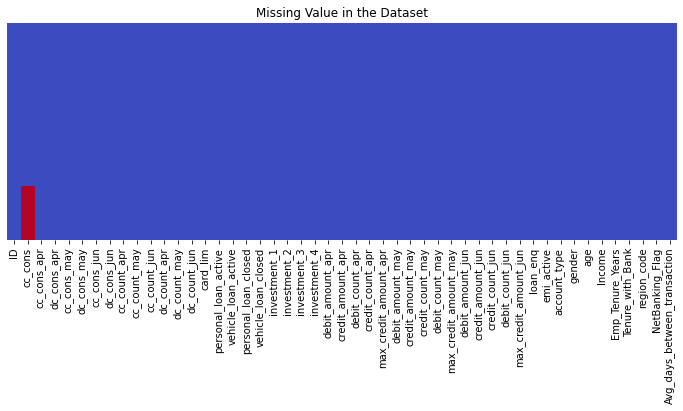

In [86]:
plt.figure(figsize=(12,4))
sns.heatmap(fm1.isnull(),cbar=False,cmap='coolwarm',yticklabels=False)
plt.title('Missing Value in the Dataset');

In [87]:
#Extracting the cc columns with two different data types
train=fm1[~fm1.cc_cons.isnull()]
test=fm1[fm1.cc_cons.isnull()]

In [88]:
train

,ID,cc_cons,cc_cons_apr,dc_cons_apr,cc_cons_may,dc_cons_may,cc_cons_jun,dc_cons_jun,cc_count_apr,cc_count_may,...,emi_active,account_type,gender,age,Income,Emp_Tenure_Years,Tenure_with_Bank,region_code,NetBanking_Flag,Avg_days_between_transaction
0,12554,20014.0,24893.00,378.00,10288.00,29664.00,16291.40,11432.00,2.0,26,...,1674.09,0,1,35,2,15.0,1,708.0,0,17.0
1,17645,10173.0,18941.62,966.00,20672.00,287.00,4217.00,885.00,1.0,7,...,13043.34,0,1,35,0,15.0,6,123.0,0,14.0
2,7604,16095.0,5678.87,2724.00,1964.50,3933.11,23956.25,5168.00,43.0,32,...,25375.27,0,1,55,2,24.5,1,802.0,1,3.0
3,1590,7707.0,30489.50,1236.00,12609.88,9138.14,17521.00,13650.30,53.0,1,...,3544.33,0,0,29,2,4.5,6,867.0,1,4.0
4,16556,96408.0,7441.40,6906.04,4364.00,1939.00,2121.00,6829.18,67.0,47,...,12780.44,0,1,34,2,12.6,4,802.0,1,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,6995,4263.0,10443.76,1218.85,7252.24,3873.00,6633.00,10107.00,3.0,36,...,78966.76,0,0,53,1,13.2,9,653.0,1,20.0
14996,10376,11019.0,29890.33,6308.00,16025.50,7610.00,2213.08,841.60,1.0,34,...,4762.10,0,1,44,2,2.4,9,535.0,1,2.0
14997,2181,404227.0,4148.98,948.74,19360.26,494.00,44363.91,1801.77,57.0,23,...,2877.33,0,1,37,2,3.4,9,464.0,1,8.0
14998,18417,28813.0,115574.00,7191.05,44341.13,34817.20,20679.00,1010.00,7.0,128,...,13006.84,0,1,220,2,40.0,10,536.0,1,3.0


## Train and Test sets

In [89]:
xtrain=fm1[~fm1['cc_cons'].isnull()]
xtest=fm1[fm1['cc_cons'].isnull()]
print(xtrain)
print(xtest)

ytrain=fm1[~fm1['cc_cons'].isnull()]['cc_cons']
ytest=fm1[fm1['cc_cons'].isnull()]['cc_cons']
print(ytrain)
print(ytest)

          ID   cc_cons  cc_cons_apr  dc_cons_apr  cc_cons_may  dc_cons_may  \
0      12554   20014.0     24893.00       378.00     10288.00     29664.00   
1      17645   10173.0     18941.62       966.00     20672.00       287.00   
2       7604   16095.0      5678.87      2724.00      1964.50      3933.11   
3       1590    7707.0     30489.50      1236.00     12609.88      9138.14   
4      16556   96408.0      7441.40      6906.04      4364.00      1939.00   
...      ...       ...          ...          ...          ...          ...   
14995   6995    4263.0     10443.76      1218.85      7252.24      3873.00   
14996  10376   11019.0     29890.33      6308.00     16025.50      7610.00   
14997   2181  404227.0      4148.98       948.74     19360.26       494.00   
14998  18417   28813.0    115574.00      7191.05     44341.13     34817.20   
14999   4547   16252.0      7375.67       306.80      5859.49      6702.40   

       cc_cons_jun  dc_cons_jun  cc_count_apr  cc_count_may  ..

### Missing Data Imputation


In [90]:
#Missing data x_train
total=xtrain.isnull().sum().sort_values(ascending=False)
percent=xtrain.isnull().sum() / xtrain.isnull().count().sort_values(ascending=False)
missing_data=pd.concat([total,percent],axis=1,keys=['total','percent'])
missing_data.head(10)

,total,percent
investment_3,2,0.000133
Avg_days_between_transaction,1,0.000067
cc_count_apr,1,0.000067
personal_loan_closed,1,0.000067
emi_active,1,0.000067
debit_count_apr,1,0.000067
Income,0,0.000000
age,0,0.000000
debit_amount_may,0,0.000000
credit_amount_may,0,0.000000


In [91]:
xtrain.isnull().sum().sum()

7

In [92]:
#Missing Data x_test
total=xtest.isnull().sum().sort_values(ascending=False)
percent=xtest.isnull().sum() / xtest.isnull().count().sort_values(ascending=False)
missing_data=pd.concat([total,percent],axis=1,keys=['total','percent'])
missing_data.head(10)

,total,percent
cc_cons,5000,1.0000
Avg_days_between_transaction,2,0.0004
region_code,1,0.0002
cc_cons_may,1,0.0002
dc_cons_jun,1,0.0002
debit_count_jun,0,0.0000
debit_amount_may,0,0.0000
credit_amount_may,0,0.0000
credit_count_may,0,0.0000
debit_count_may,0,0.0000


In [93]:
xtest.isnull().sum().sum()

5005

### Missing Value Imputation

In [94]:
xtrain=xtrain.apply(missing_imputation)

In [95]:
xtrain.isnull().sum().sum()

0

In [96]:
xtest=xtest.apply(missing_imputation)

In [97]:
xtest.isnull().sum().sum()

5000

### Cleaning Data Sets

In [98]:
xtrain=xtrain.replace((np.inf,-np.inf,np.nan), 0).reset_index(drop=True)
print("xtrain",xtrain)
ytrain=ytrain.replace((np.inf,-np.inf,np.nan), 0).reset_index(drop=True)
print("ytrain",ytrain)
xtest=xtest.replace((np.inf,-np.inf,np.nan), 0).reset_index(drop=True)
print('xtest',xtest)
ytest=ytest.replace((np.inf,-np.inf,np.nan), 0).reset_index(drop=True)
print("ytest",ytest)

xtrain           ID   cc_cons  cc_cons_apr  dc_cons_apr  cc_cons_may  dc_cons_may  \
0      12554   20014.0     24893.00       378.00     10288.00     29664.00   
1      17645   10173.0     18941.62       966.00     20672.00       287.00   
2       7604   16095.0      5678.87      2724.00      1964.50      3933.11   
3       1590    7707.0     30489.50      1236.00     12609.88      9138.14   
4      16556   96408.0      7441.40      6906.04      4364.00      1939.00   
...      ...       ...          ...          ...          ...          ...   
14995   6995    4263.0     10443.76      1218.85      7252.24      3873.00   
14996  10376   11019.0     29890.33      6308.00     16025.50      7610.00   
14997   2181  404227.0      4148.98       948.74     19360.26       494.00   
14998  18417   28813.0    115574.00      7191.05     44341.13     34817.20   
14999   4547   16252.0      7375.67       306.80      5859.49      6702.40   

       cc_cons_jun  dc_cons_jun  cc_count_apr  cc_count_

## Linnear Regression Model

In [99]:
from sklearn.linear_model import LinearRegression
model=LinearRegression()
model=model.fit(xtrain,ytrain)
model

LinearRegression()

### Intercept

In [100]:
model.intercept_

2.1827872842550278e-11

### Co-efficient

In [101]:
model.coef_

array([ 2.15388249e-16,  1.00000000e+00,  5.87724314e-15, -1.36002321e-15,
       -3.21964677e-15,  2.74086309e-15, -2.66453526e-15, -2.08166817e-14,
        6.76861345e-13,  1.40622954e-12, -1.80106986e-12,  2.82591665e-12,
       -2.17006590e-12,  2.00470547e-13,  4.85722573e-16, -3.46944695e-18,
       -1.94289029e-16, -2.77555756e-17,  2.77555756e-17, -2.77555756e-16,
       -2.22044605e-16, -6.10622664e-16, -7.91033905e-16,  1.38777878e-16,
        9.02056208e-17, -2.02858292e-15, -1.30641438e-13,  1.24900090e-16,
        6.93889390e-16, -1.11022302e-16,  1.97858087e-14, -2.15808410e-14,
        3.33066907e-16, -4.23272528e-16,  2.91433544e-16,  1.72491280e-14,
       -5.55890783e-15, -2.77555756e-17, -6.04966613e-11,  5.82867088e-16,
        5.34151906e-13, -6.94578478e-13,  1.84177489e-14,  2.58497963e-12,
       -1.96822335e-14,  1.01946290e-14,  1.54071634e-14,  2.13664027e-12,
       -4.06443728e-14])

## Prdicting the model

In [102]:
predictions = model.predict(xtest)
predictions= predictions.reshape(-1,1)

In [103]:
from sklearn import metrics
print('MAE:',metrics.mean_absolute_error(ytest,predictions))
print('MSE:', metrics.mean_squared_error(ytest, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(ytest, predictions)))

MAE: 3.6757289753658024e-10
MSE: 6.537153185266191e-19
RMSE: 8.085266343953173e-10
